# **SALINAS**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 20.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -2].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ModuleNotFoundError: No module named 'catboost'

In [ ]:
# Train CatBoost Model
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")
catboost_classifier.fit(X_train, y_train)

# Extract probability-based features
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors
X_test_embeddings = catboost_classifier.predict_proba(X_test)    # Probability vectors

Training CatBoost model...
0:	learn: 2.0085110	total: 14ms	remaining: 14s
50:	learn: 0.4230325	total: 570ms	remaining: 10.6s
100:	learn: 0.3447465	total: 1.09s	remaining: 9.7s
150:	learn: 0.3069079	total: 1.61s	remaining: 9.07s
200:	learn: 0.2845419	total: 2.13s	remaining: 8.45s
250:	learn: 0.2653434	total: 2.65s	remaining: 7.9s
300:	learn: 0.2514766	total: 3.15s	remaining: 7.32s
350:	learn: 0.2394128	total: 3.66s	remaining: 6.77s
400:	learn: 0.2288311	total: 4.17s	remaining: 6.23s
450:	learn: 0.2210918	total: 4.68s	remaining: 5.69s
500:	learn: 0.2129307	total: 5.19s	remaining: 5.17s
550:	learn: 0.2054780	total: 5.69s	remaining: 4.64s
600:	learn: 0.1992594	total: 6.2s	remaining: 4.12s
650:	learn: 0.1933622	total: 6.72s	remaining: 3.6s
700:	learn: 0.1877701	total: 7.23s	remaining: 3.08s
750:	learn: 0.1825624	total: 7.74s	remaining: 2.57s
800:	learn: 0.1780695	total: 8.27s	remaining: 2.05s
850:	learn: 0.1739742	total: 8.77s	remaining: 1.53s
900:	learn: 0.1695220	total: 9.28s	remaining: 1

In [ ]:
# Convert embeddings to tensors
X_train_tensor = torch.tensor(X_train_embeddings, dtype=torch.float32, device=device)  # Shape: (num_samples, 204)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32, device=device)  # Shape: (num_samples, 204)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

In [ ]:
# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

In [ ]:
# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for _ in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])  # No augmentation
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Create Few-Shot Data from CatBoost Features
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X_train_embeddings, y_train, n_way, k_shot, query_per_class, episodes)

In [ ]:
# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300, n_way=5, k_shot=5):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x, n_way, k_shot)  # Pass n_way and k_shot
            loss = criterion(outputs, query_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Corrected test input
print(f"Feature Extractor Output Shape: {model.feature_extractor(torch.randn(1, 204, 1, device=device)).shape}")

train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

Feature Extractor Output Shape: torch.Size([1, 256])
Epoch 1/300, Loss: 123.7458, Accuracy: 91.91%
Epoch 2/300, Loss: 92.8703, Accuracy: 93.88%
Epoch 3/300, Loss: 81.7201, Accuracy: 94.61%
Epoch 4/300, Loss: 72.6842, Accuracy: 95.17%
Epoch 5/300, Loss: 66.3997, Accuracy: 95.58%
Epoch 6/300, Loss: 61.8925, Accuracy: 95.87%
Epoch 7/300, Loss: 58.6532, Accuracy: 96.04%
Epoch 8/300, Loss: 55.6831, Accuracy: 96.34%
Epoch 9/300, Loss: 53.8553, Accuracy: 96.44%
Epoch 10/300, Loss: 51.6266, Accuracy: 96.42%
Epoch 11/300, Loss: 49.4112, Accuracy: 96.60%
Epoch 12/300, Loss: 48.5955, Accuracy: 96.64%
Epoch 13/300, Loss: 47.1084, Accuracy: 96.74%
Epoch 14/300, Loss: 46.4543, Accuracy: 96.88%
Epoch 15/300, Loss: 45.6811, Accuracy: 96.89%
Epoch 16/300, Loss: 44.7767, Accuracy: 96.98%
Epoch 17/300, Loss: 44.0031, Accuracy: 96.97%
Epoch 18/300, Loss: 43.6173, Accuracy: 97.03%
Epoch 19/300, Loss: 42.9628, Accuracy: 97.18%
Epoch 20/300, Loss: 43.2244, Accuracy: 97.07%
Epoch 21/300, Loss: 41.2989, Accura

In [ ]:
def evaluate_few_shot_model(model, data, n_way=5, k_shot=5):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradient calculation for evaluation
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            # Forward pass through the model
            outputs = model(support_x, query_x, n_way, k_shot)  # Get distance scores

            # Get predicted labels (class with minimum distance)
            predicted_labels = outputs.argmax(dim=1)

            # Compare predictions with ground truth
            total_correct += (predicted_labels == query_y).sum().item()
            total_samples += query_y.size(0)

    # Compute overall accuracy
    overall_accuracy = (total_correct / total_samples) * 100
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy

overall_acc = evaluate_few_shot_model(model, few_shot_data, n_way=5, k_shot=5)

Overall Accuracy: 98.19%


In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "FS+CAT_Boost_Salinas.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/FS+CAT_Boost_Salinas.pth


In [ ]:
import pandas as pd

# Load the datasets
salinas_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
salinas_gt_path = "/content/drive/MyDrive/Salinas_GT.csv"

# Read the datasets
salinas_data = pd.read_csv(salinas_data_path)
salinas_gt = pd.read_csv(salinas_gt_path)

# Display basic info and first few rows
salinas_data.info(), salinas_data.head(), salinas_gt.info(), salinas_gt.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111104 entries, 0 to 111103
Columns: 205 entries, band-1 to class
dtypes: int64(205)
memory usage: 173.8 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111104 entries, 0 to 111103
Columns: 206 entries, band-1 to Class_Label
dtypes: int64(206)
memory usage: 174.6 MB


(None,
    band-1  band-2  band-3  band-4  band-5  band-6  band-7  band-8  band-9  \
 0     290     381     585    1041    1316    1397    1319    1462    1643   
 1     290     381     519    1041    1316    1352    1319    1462    1643   
 2     290     381     585    1041    1286    1352    1300    1412    1614   
 3     290     381     585     999    1316    1374    1280    1380    1584   
 4     219     381     585     999    1286    1352    1261    1396    1555   
 
    band-10  ...  band-196  band-197  band-198  band-199  band-200  band-201  \
 0     1683  ...        96       109        93        54        79        54   
 1     1683  ...        94       111        96        56        83        56   
 2     1644  ...        88       107        89        54        81        54   
 3     1631  ...        86       105        85        56        75        50   
 4     1618  ...        83       105        83        48        75        50   
 
    band-202  band-203  band-204  class  

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 17.8 MB/s eta 0:00:00


In [ ]:
!pip uninstall -y numpy catboost
!pip install numpy catboost --upgrade

Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: catboost 1.2.7
Uninstalling catboost-1.2.7:
  Successfully uninstalled catboost-1.2.7
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 2.9 MB/s eta 0:00:00
  Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl.metadata (1.2 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 5.4 MB/s eta 0:00:00
Using cached catboost-1.2.7-cp311-cp311-manylinux2014_x86_64.whl (98.7 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 84.6 MB/s eta 0:00:00


Using device: cuda
Training CatBoost model...
0:	learn: 2.0085108	total: 27.3ms	remaining: 27.3s
50:	learn: 0.4230322	total: 893ms	remaining: 16.6s
100:	learn: 0.3447465	total: 1.75s	remaining: 15.6s
150:	learn: 0.3069078	total: 2.62s	remaining: 14.7s
200:	learn: 0.2845419	total: 3.48s	remaining: 13.8s
250:	learn: 0.2653435	total: 4.33s	remaining: 12.9s
300:	learn: 0.2514765	total: 5.18s	remaining: 12s
350:	learn: 0.2394127	total: 6.04s	remaining: 11.2s
400:	learn: 0.2288310	total: 6.9s	remaining: 10.3s
450:	learn: 0.2210917	total: 7.73s	remaining: 9.41s
500:	learn: 0.2129306	total: 8.6s	remaining: 8.56s
550:	learn: 0.2054779	total: 9.45s	remaining: 7.7s
600:	learn: 0.1992594	total: 10.3s	remaining: 6.83s
650:	learn: 0.1933622	total: 11.2s	remaining: 5.98s
700:	learn: 0.1877701	total: 12s	remaining: 5.12s
750:	learn: 0.1825624	total: 12.9s	remaining: 4.27s
800:	learn: 0.1780695	total: 13.7s	remaining: 3.41s
850:	learn: 0.1739742	total: 14.6s	remaining: 2.55s
900:	learn: 0.1695220	total

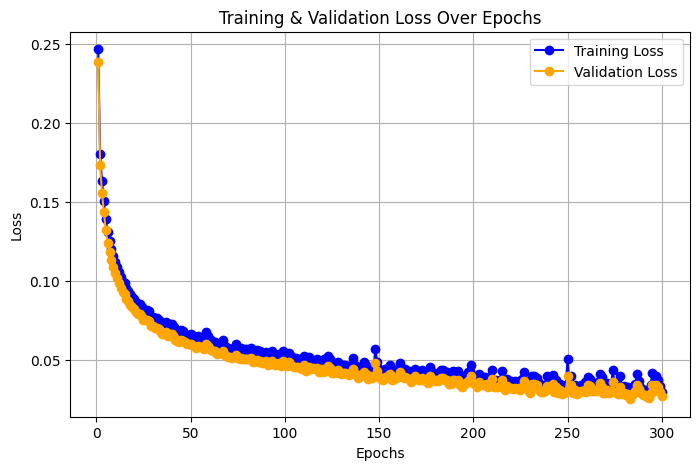

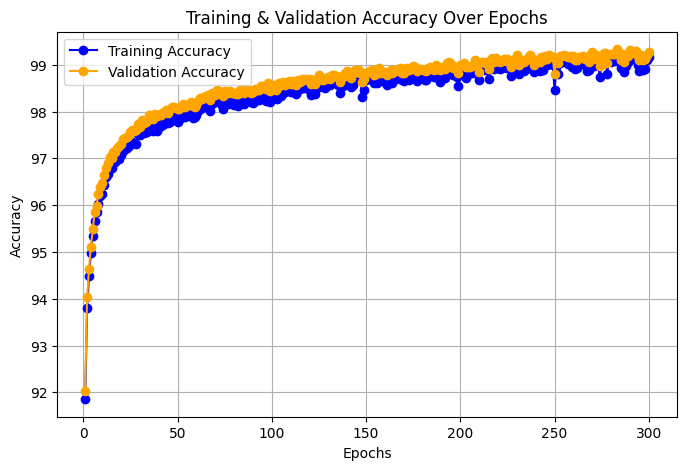

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, classification_report
import torch.cuda.memory as memory

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 204  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(204, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/Salinas_Dataset.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/Salinas_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -2].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train CatBoost Model
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")
catboost_classifier.fit(X_train, y_train)

# Extract probability-based features
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors
X_test_embeddings = catboost_classifier.predict_proba(X_test)    # Probability vectors

# Convert embeddings to tensors
X_train_tensor = torch.tensor(X_train_embeddings, dtype=torch.float32, device=device)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32, device=device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for _ in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Create Few-Shot Data
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X_train_embeddings, y_train, n_way, k_shot, query_per_class, episodes)

# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Training with Time & Memory Tracking
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

start_time = time.time()
peak_memory = 0

def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300, n_way=5, k_shot=5):
    global peak_memory
    model.train()

    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        val_loss, val_correct, val_samples = 0, 0, 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x, n_way, k_shot)
            loss = criterion(outputs, query_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

            # Validation Loss Calculation
            with torch.no_grad():
                val_outputs = model(support_x, query_x, n_way, k_shot)
                val_loss += criterion(val_outputs, query_y).item()
                val_correct += (val_outputs.argmax(dim=1) == query_y).sum().item()
                val_samples += query_y.size(0)

            # Update Peak Memory
            peak_memory = max(peak_memory, memory.max_memory_allocated(device))

        train_losses.append(total_loss / len(data))
        val_losses.append(val_loss / len(data))
        train_accuracies.append(total_correct / total_samples * 100)
        val_accuracies.append(val_correct / val_samples * 100)

        print(f"Epoch {epoch+1}/{epochs} - Train Acc: {train_accuracies[-1]:.2f}%, "
              f"Val Acc: {val_accuracies[-1]:.2f}%, Peak Mem: {peak_memory / 1e6:.2f} MB")

train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

# End Training Timer
end_time = time.time()
print(f"Total Training Time: {end_time - start_time:.2f} seconds")
print(f"Peak Memory Usage: {peak_memory / 1e6:.2f} MB")

# Evaluation
def evaluate_few_shot_model(model, data, n_way=5, k_shot=5):
    model.eval()
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            outputs = model(support_x, query_x, n_way, k_shot)
            predicted_labels = outputs.argmax(dim=1)

            total_correct += (predicted_labels == query_y).sum().item()
            total_samples += query_y.size(0)

    overall_accuracy = (total_correct / total_samples) * 100
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy

overall_acc = evaluate_few_shot_model(model, few_shot_data, n_way=5, k_shot=5)

# Plot Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)


# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.show()

# **IP**

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.metrics import accuracy_score, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load Spectral Data
spectral_data_path = "/content/drive/MyDrive/IndianPines.csv"
df_spectral = pd.read_csv(spectral_data_path)

# Load Ground Truth Data
ground_truth_path = "/content/drive/MyDrive/IP_GT.csv"
df_gt = pd.read_csv(ground_truth_path)

# Extract Features and Labels
X = df_spectral.iloc[:, :-1].values  # First 204 columns as spectral features
y = df_gt.iloc[:, -1].values  # Last column as true class labels

# Normalize Features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

Using device: cuda


In [ ]:
# Train CatBoost Model
catboost_classifier = CatBoostClassifier(
    iterations=1000,
    depth=6,
    learning_rate=0.1,
    loss_function="MultiClass",
    eval_metric="MultiClass",
    task_type="GPU",
    verbose=50
)

print("Training CatBoost model...")
catboost_classifier.fit(X_train, y_train)

# Extract probability-based features
X_train_embeddings = catboost_classifier.predict_proba(X_train)  # Probability vectors
X_test_embeddings = catboost_classifier.predict_proba(X_test)    # Probability vectors

Training CatBoost model...
0:	learn: 2.2220085	total: 13.9ms	remaining: 13.9s
50:	learn: 0.8367108	total: 711ms	remaining: 13.2s
100:	learn: 0.7054697	total: 1.42s	remaining: 12.7s
150:	learn: 0.6279998	total: 2.13s	remaining: 12s
200:	learn: 0.5726934	total: 2.84s	remaining: 11.3s
250:	learn: 0.5297150	total: 3.56s	remaining: 10.6s
300:	learn: 0.4948440	total: 4.26s	remaining: 9.89s
350:	learn: 0.4644328	total: 4.97s	remaining: 9.19s
400:	learn: 0.4384006	total: 5.67s	remaining: 8.47s
450:	learn: 0.4154144	total: 6.38s	remaining: 7.76s
500:	learn: 0.3951338	total: 7.08s	remaining: 7.05s
550:	learn: 0.3739627	total: 7.79s	remaining: 6.35s
600:	learn: 0.3566610	total: 8.49s	remaining: 5.64s
650:	learn: 0.3404487	total: 9.21s	remaining: 4.93s
700:	learn: 0.3256420	total: 9.91s	remaining: 4.23s
750:	learn: 0.3117100	total: 10.6s	remaining: 3.52s
800:	learn: 0.2987862	total: 11.3s	remaining: 2.81s
850:	learn: 0.2857438	total: 12s	remaining: 2.11s
900:	learn: 0.2731399	total: 12.8s	remainin

In [ ]:
# Convert embeddings to tensors
# Use original spectral features instead of CatBoost probabilities
X_train_tensor = torch.tensor(X_train_embeddings, dtype=torch.float32, device=device)  # Shape: (num_samples, 204)
X_test_tensor = torch.tensor(X_test_embeddings, dtype=torch.float32, device=device)  # Shape: (num_samples, 204)
y_train_tensor = torch.tensor(y_train, dtype=torch.long, device=device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long, device=device)

In [ ]:
# Improved Feature Extractor (From Probability Features)
class SpectralFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, 9, padding=4)
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 128, 7, padding=3)
        self.bn2 = nn.BatchNorm1d(128)
        self.conv3 = nn.Conv1d(128, 256, 5, padding=2)
        self.bn3 = nn.BatchNorm1d(256)

        # Compute the output feature size dynamically
        self.flattened_size = 256 * 200  # Since input has 204 spectral bands
        self.fc = nn.Linear(self.flattened_size, 256)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten
        return self.fc(x)

# Prototypical Network for Few-Shot Learning
import torch
import torch.nn as nn
import torch.nn.functional as F

class PrototypicalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.feature_extractor = nn.Sequential(
            nn.Conv1d(200, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten(),
            nn.Linear(128, 256)
        )

    def euclidean_distance(self, query, prototypes):
        return -torch.cdist(query, prototypes, p=2)  # Negative distance for loss minimization

    def forward(self, support, query, n_way, k_shot):
        support_embeddings = self.feature_extractor(support)  # (n_way * k_shot, feature_dim)
        query_embeddings = self.feature_extractor(query)  # (n_queries, feature_dim)

        # Reshape support embeddings to compute class prototypes
        try:
            prototypes = support_embeddings.view(n_way, k_shot, -1).mean(dim=1)  # Shape: (n_way, feature_dim)
        except RuntimeError as e:
            print(f"Error in reshaping: {e}")
            print(f"Expected reshape to ({n_way}, {k_shot}, -1), but got {support_embeddings.shape}")
            raise

        # Compute distances
        dists = self.euclidean_distance(query_embeddings, prototypes)  # Shape: (n_queries, n_way)
        return dists  # No need for softmax, as loss function applies it

In [ ]:
# Few-Shot Data Creation
def create_few_shot_batches(X, y, n_way=5, k_shot=5, query_per_class=10, episodes=500):
    unique_classes = np.unique(y)
    dataset = []

    for _ in range(episodes):
        selected_classes = np.random.choice(unique_classes, n_way, replace=False)
        support_set, query_set = [], []
        support_labels, query_labels = [], []

        for i, cls in enumerate(selected_classes):
            indices = np.where(y == cls)[0]
            selected_indices = np.random.choice(indices, k_shot + query_per_class, replace=False)

            support_set.append(X[selected_indices[:k_shot]])  # No augmentation
            query_set.append(X[selected_indices[k_shot:]])
            support_labels.extend([i] * k_shot)
            query_labels.extend([i] * query_per_class)

        dataset.append((np.vstack(support_set), np.array(support_labels),
                        np.vstack(query_set), np.array(query_labels)))

    return dataset

# Create Few-Shot Data from CatBoost Features
n_way, k_shot, query_per_class = 5, 5, 10
episodes = 500
few_shot_data = create_few_shot_batches(X_train_embeddings, y_train, n_way, k_shot, query_per_class, episodes)

In [ ]:
# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Training Function
def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300, n_way=5, k_shot=5):
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        total_correct = 0
        total_samples = 0

        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x, n_way, k_shot)  # Pass n_way and k_shot
            loss = criterion(outputs, query_y)

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        epoch_acc = total_correct / total_samples * 100
        print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

# Corrected test input
print(f"Feature Extractor Output Shape: {model.feature_extractor(torch.randn(1, 200, 1, device=device)).shape}")

train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

Feature Extractor Output Shape: torch.Size([1, 256])
Epoch 1/300, Loss: 223.4005, Accuracy: 82.30%
Epoch 2/300, Loss: 158.4022, Accuracy: 88.06%
Epoch 3/300, Loss: 138.6836, Accuracy: 89.77%
Epoch 4/300, Loss: 127.3331, Accuracy: 90.80%
Epoch 5/300, Loss: 119.5938, Accuracy: 91.44%
Epoch 6/300, Loss: 112.9447, Accuracy: 92.05%
Epoch 7/300, Loss: 108.5735, Accuracy: 92.37%
Epoch 8/300, Loss: 104.5267, Accuracy: 92.60%
Epoch 9/300, Loss: 99.9758, Accuracy: 92.95%
Epoch 10/300, Loss: 96.0796, Accuracy: 93.28%
Epoch 11/300, Loss: 91.4611, Accuracy: 93.69%
Epoch 12/300, Loss: 88.5202, Accuracy: 93.78%
Epoch 13/300, Loss: 85.3867, Accuracy: 94.11%
Epoch 14/300, Loss: 82.4377, Accuracy: 94.30%
Epoch 15/300, Loss: 80.0376, Accuracy: 94.47%
Epoch 16/300, Loss: 77.7373, Accuracy: 94.66%
Epoch 17/300, Loss: 75.8404, Accuracy: 94.84%
Epoch 18/300, Loss: 73.2432, Accuracy: 95.02%
Epoch 19/300, Loss: 71.9356, Accuracy: 95.08%
Epoch 20/300, Loss: 69.9239, Accuracy: 95.20%
Epoch 21/300, Loss: 68.3076,

In [ ]:
def evaluate_few_shot_model(model, data, n_way=5, k_shot=5):
    model.eval()  # Set model to evaluation mode
    total_correct = 0
    total_samples = 0

    with torch.no_grad():  # No gradient calculation for evaluation
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            # Forward pass through the model
            outputs = model(support_x, query_x, n_way, k_shot)  # Get distance scores

            # Get predicted labels (class with minimum distance)
            predicted_labels = outputs.argmax(dim=1)

            # Compare predictions with ground truth
            total_correct += (predicted_labels == query_y).sum().item()
            total_samples += query_y.size(0)

    # Compute overall accuracy
    overall_accuracy = (total_correct / total_samples) * 100
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    return overall_accuracy

overall_acc = evaluate_few_shot_model(model, few_shot_data, n_way=5, k_shot=5)

Overall Accuracy: 98.92%


In [ ]:
import os
import torch

# Define model directory and path
model_dir = "/content/drive/MyDrive/Model_Checkpoints"
model_save_path = os.path.join(model_dir, "FS+CATBoost_IP.pth")

# Create directory if it doesn't exist
os.makedirs(model_dir, exist_ok=True)

# Save the model
torch.save(model.state_dict(), model_save_path)

print(f"Model saved at: {model_save_path}")

Model saved at: /content/drive/MyDrive/Model_Checkpoints/FS+CATBoost_IP.pth


Epoch 1/300, Train Acc: 82.92%, Val Acc: 87.24%
Epoch 2/300, Train Acc: 88.32%, Val Acc: 89.48%
Epoch 3/300, Train Acc: 90.16%, Val Acc: 90.43%
Epoch 4/300, Train Acc: 91.02%, Val Acc: 91.10%
Epoch 5/300, Train Acc: 91.52%, Val Acc: 91.69%
Epoch 6/300, Train Acc: 91.99%, Val Acc: 92.33%
Epoch 7/300, Train Acc: 92.49%, Val Acc: 92.40%
Epoch 8/300, Train Acc: 92.84%, Val Acc: 92.80%
Epoch 9/300, Train Acc: 93.12%, Val Acc: 92.87%
Epoch 10/300, Train Acc: 93.37%, Val Acc: 93.31%
Epoch 11/300, Train Acc: 93.66%, Val Acc: 93.36%
Epoch 12/300, Train Acc: 93.92%, Val Acc: 93.79%
Epoch 13/300, Train Acc: 94.16%, Val Acc: 93.95%
Epoch 14/300, Train Acc: 94.24%, Val Acc: 94.06%
Epoch 15/300, Train Acc: 94.56%, Val Acc: 94.48%
Epoch 16/300, Train Acc: 94.76%, Val Acc: 94.56%
Epoch 17/300, Train Acc: 94.90%, Val Acc: 94.58%
Epoch 18/300, Train Acc: 94.94%, Val Acc: 94.88%
Epoch 19/300, Train Acc: 95.16%, Val Acc: 94.96%
Epoch 20/300, Train Acc: 95.38%, Val Acc: 95.08%
Epoch 21/300, Train Acc: 95.4

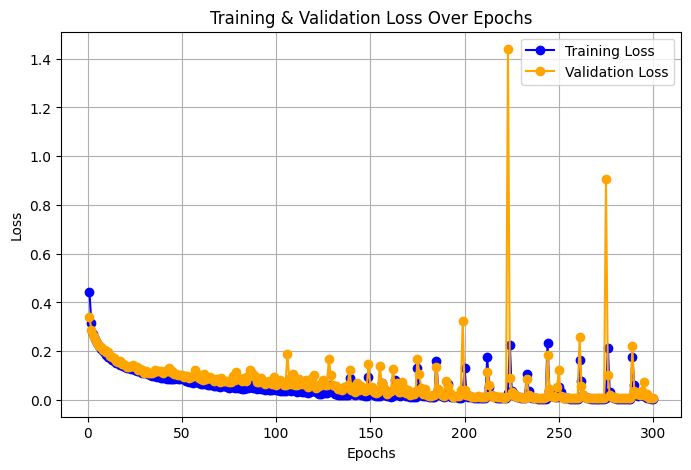

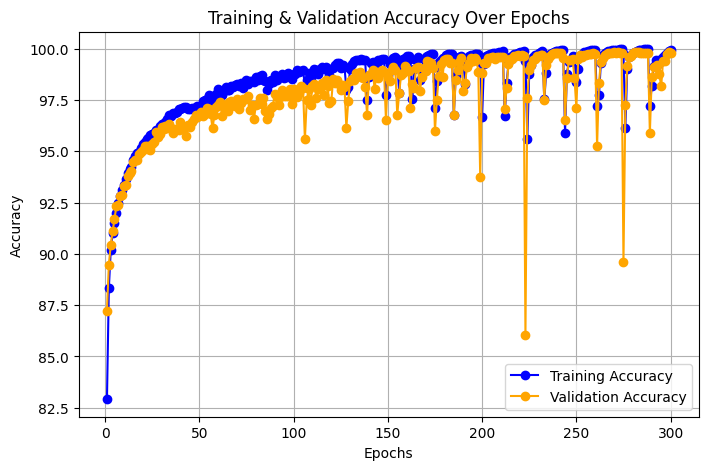

In [ ]:
import time
import torch.cuda as cuda
import matplotlib.pyplot as plt

# Initialize Model
model = PrototypicalNetwork().to(device)
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=5e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
criterion = nn.CrossEntropyLoss()

# Lists to store loss and accuracy
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

def train_few_shot_model(model, data, optimizer, criterion, scheduler, epochs=300, n_way=5, k_shot=5):
    model.train()

    start_time = time.time()  # Start time tracking
    cuda.reset_peak_memory_stats(device)  # Reset memory tracking

    for epoch in range(epochs):
        total_loss, total_correct, total_samples = 0, 0, 0
        val_loss, val_correct, val_samples = 0, 0, 0

        # Training
        for support_x, support_y, query_x, query_y in data:
            support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
            query_y = torch.tensor(query_y, dtype=torch.long, device=device)

            optimizer.zero_grad()
            outputs = model(support_x, query_x, n_way, k_shot)
            loss = criterion(outputs, query_y)
            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            total_correct += (outputs.argmax(dim=1) == query_y).sum().item()
            total_samples += query_y.size(0)

        # Store training metrics
        train_losses.append(total_loss / len(data))
        train_accuracies.append(total_correct / total_samples * 100)

        # Validation
        model.eval()
        with torch.no_grad():
            for support_x, support_y, query_x, query_y in data:
                support_x = torch.tensor(support_x, dtype=torch.float32, device=device).unsqueeze(-1)
                query_x = torch.tensor(query_x, dtype=torch.float32, device=device).unsqueeze(-1)
                query_y = torch.tensor(query_y, dtype=torch.long, device=device)

                outputs = model(support_x, query_x, n_way, k_shot)
                loss = criterion(outputs, query_y)

                val_loss += loss.item()
                val_correct += (outputs.argmax(dim=1) == query_y).sum().item()
                val_samples += query_y.size(0)

        # Store validation metrics
        val_losses.append(val_loss / len(data))
        val_accuracies.append(val_correct / val_samples * 100)

        print(f"Epoch {epoch+1}/{epochs}, Train Acc: {train_accuracies[-1]:.2f}%, Val Acc: {val_accuracies[-1]:.2f}%")

    end_time = time.time()  # End time tracking
    training_time = end_time - start_time  # Calculate total training time
    peak_memory = cuda.max_memory_allocated(device) / (1024 ** 2)  # Peak memory in MB

    print(f"\nTotal Training Time: {training_time:.2f} seconds")
    print(f"Peak GPU Memory Usage: {peak_memory:.2f} MB")

# Train the model
train_few_shot_model(model, few_shot_data, optimizer, criterion, scheduler)

# Plot Loss and Accuracy
epochs_range = range(1, len(train_losses) + 1)

# Loss Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_losses, label="Training Loss", marker='o', color='blue')
plt.plot(epochs_range, val_losses, label="Validation Loss", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Over Epochs")
plt.legend()
plt.grid(True)


# Accuracy Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs_range, train_accuracies, label="Training Accuracy", marker='o', color='blue')
plt.plot(epochs_range, val_accuracies, label="Validation Accuracy", marker='o', color='orange')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy Over Epochs")
plt.legend()
plt.grid(True)

plt.show()